# Microstate analysis with Pycrostates

In [1]:
import mne
import numpy as np
import os
import pickle
import pycrostates
import seaborn as sns
import time

from matplotlib import pyplot as plt
from mne.io import read_raw_edf

from pycrostates.cluster import ModKMeans
from pycrostates.io import ChData
from pycrostates.preprocessing import extract_gfp_peaks

In [2]:
sleep_stages = ['W', 'N1', 'N2', 'N3']

In [4]:
data_dir = "../data"
all_files = os.listdir(data_dir)
print(f"All files n = {len(all_files):d}")

All files n = 60


In [5]:
files = {
    stage : [f"{data_dir:s}/{f:s}" for f in all_files if f.endswith(f'_{stage:s}.edf')] 
    for stage in sleep_stages
}
for stage in sleep_stages:
    print(f"\nSleep stage: {stage:s}")
    for i, f in enumerate(files[stage]):
        print(f"{i:d}: {f:s}")


Sleep stage: W
0: ../data/S13_W.edf
1: ../data/S02_W.edf
2: ../data/S09_W.edf
3: ../data/S11_W.edf
4: ../data/S05_W.edf
5: ../data/S00_W.edf
6: ../data/S08_W.edf
7: ../data/S01_W.edf
8: ../data/S10_W.edf
9: ../data/S12_W.edf
10: ../data/S14_W.edf
11: ../data/S03_W.edf
12: ../data/S06_W.edf
13: ../data/S04_W.edf
14: ../data/S07_W.edf

Sleep stage: N1
0: ../data/S07_N1.edf
1: ../data/S12_N1.edf
2: ../data/S08_N1.edf
3: ../data/S03_N1.edf
4: ../data/S14_N1.edf
5: ../data/S13_N1.edf
6: ../data/S06_N1.edf
7: ../data/S10_N1.edf
8: ../data/S11_N1.edf
9: ../data/S02_N1.edf
10: ../data/S00_N1.edf
11: ../data/S04_N1.edf
12: ../data/S09_N1.edf
13: ../data/S05_N1.edf
14: ../data/S01_N1.edf

Sleep stage: N2
0: ../data/S06_N2.edf
1: ../data/S05_N2.edf
2: ../data/S13_N2.edf
3: ../data/S04_N2.edf
4: ../data/S00_N2.edf
5: ../data/S10_N2.edf
6: ../data/S03_N2.edf
7: ../data/S07_N2.edf
8: ../data/S12_N2.edf
9: ../data/S11_N2.edf
10: ../data/S02_N2.edf
11: ../data/S01_N2.edf
12: ../data/S09_N2.edf
13: ..

## Group-level microstate clustering

In [6]:
# number of microstates
K = 5
# band-pass filter settings
bp_lo, bp_hi = (1, 30)


Sleep stage: W
1/15: ../data/S13_W.edf
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/home/frederic/miniconda3/envs/pycrostates-dev/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2/15: ../data/S02_W.edf
3/15: ../data/S09_W.edf
4/15: ../data/S11_W.edf
5/15: ../data/S05_W.edf
6/15: ../data/S00_W.edf
7/15: ../data/S08_W.edf
8/15: ../data/S01_W.edf
9/15: ../data/S10_W.edf
10/15: ../data/S12_W.edf
11/15: ../data/S14_W.edf
12/15: ../data/S03_W.edf
13/15: ../data/S06_W.edf
14/15: ../data/S04_W.edf
15/15: ../data/S07_W.edf

Sleep stage: N1
1/15: ../data/S07_N1.edf
2/15: ../data/S12_N1.edf
3/15: ../data/S08_N1.edf
4/15: ../data/S03_N1.edf
5/15: ../data/S14_N1.edf
6/15: ../data/S13_N1.edf
7/15: ../data/S06_N1.edf
8/15: ../data/S10_N1.edf
9/15: ../data/S11_N1.edf
10/15: ../data/S02_N1.edf
11/15: ../data/S00_N1.edf
12/15: ../data/S04_N1.edf
13/15: ../data/S09_N1.edf
14/15: ../data/S05_N1.edf
15/15: ../data/S01_N1.edf

Sleep stage: N2
1/15: ../data/S06_N2.edf
2/15: ../data/S05_N2.edf
3/15: ../data/S13_N2.edf
4/15: ../data/S04_N2.edf
5/15: ../data/S00_N2.edf
6/15: ../data/S10_N2.edf
7/15: ../data/S03_N2.edf
8/15: ../data/S07_N2.edf
9/15: ../data/S12_N2.edf
10/15: ../data/S11

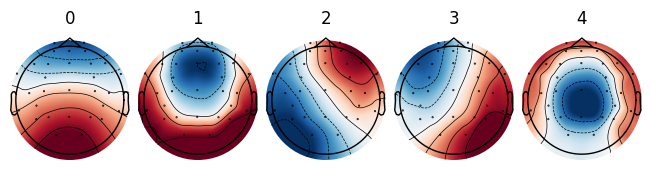

In [7]:
# this cell will take a while...
tic = time.time()
montage = mne.channels.make_standard_montage("standard_1005")
subject_level_maps = list()
for stage in sleep_stages:
    print(f"\nSleep stage: {stage:s}")
    n_files = len(files[stage])
    for i, f in enumerate(files[stage]):
        print(f"{i+1:d}/{n_files:d}: {f:s}")
        raw = read_raw_edf(f, preload=True, verbose=False)
        raw.set_montage(montage)
        raw.pick("eeg")
        raw.filter(l_freq=bp_lo, h_freq=bp_hi)
        raw.set_eeg_reference("average")
        gfp_peaks = extract_gfp_peaks(raw) # extract GFP peaks
        # subject level clustering
        ModK = ModKMeans(n_clusters=K, random_state=42)
        ModK.fit(gfp_peaks, n_jobs=2)
        subject_level_maps.append(ModK.cluster_centers_)
# combine maps across all subjects and stages to obtain group maps
group_maps = np.vstack(subject_level_maps).T
group_maps = ChData(group_maps, ModK.info)
# group level clustering
ModK = ModKMeans(n_clusters=K, random_state=42)
ModK.fit(group_maps, n_jobs=2)
toc = time.time()
print(f"[+] Computation time: {toc-tic:.1f} seconds.")
ModK.plot()
plt.show()

## Sort group-level microstate template maps

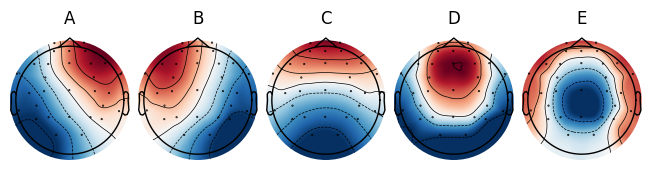

In [8]:
# only once
ModK.invert_polarity([True, True, False, True, False])
ModK.reorder_clusters(order=[2, 3, 0, 1, 4])
ModK.rename_clusters(new_names=["A", "B", "C", "D", "E"])
ModK.plot()
plt.show()

## Save group-level microstate template maps

In [9]:
# save the whole ModK object as pickle
with open(f"sleep_group_maps_K{K:d}.pkl", 'wb') as fp:
    pickle.dump(ModK, fp, protocol=pickle.HIGHEST_PROTOCOL)
# save array data only in NumPy format
np.save(f"sleep_group_maps_K{K:d}_numpyndarray.npy", ModK.cluster_centers_)
del ModK

## Fit microstate sequences from group-level maps

In [10]:
# re-load group-level maps
ModK = np.load(f"sleep_group_maps_K{K:d}.pkl", allow_pickle=True)
print(ModK)

<ModKMeans | fitted on n = 5 cluster centers>


In [11]:
results_dir = "./pycrostate_results"
for stage in sleep_stages:
    print(f"\nSleep stage: {stage:s}")
    n_files = len(files[stage])
    for i, f in enumerate(files[stage]):
        print(f"{i+1:d}/{n_files:d}: {f:s}")
        # get subject ID, e.g. f=".../data/S00_W.edf" --> S00
        subj_id = f.split('/')[-1].split('.')[0].split('_')[0]
        raw = read_raw_edf(f, preload=True, verbose=False)
        #raw.set_montage(montage)
        raw.pick("eeg")
        raw.filter(l_freq=bp_lo, h_freq=bp_hi)
        raw.set_eeg_reference("average")
        # half window size b=3, lambda factor 5, as in Pascual-Marqui et al. IEEE TBME 1995
        segmentation = ModK.predict(
            raw,
            reject_by_annotation=True,
            factor=5,
            half_window_size=3,
            min_segment_length=3,
            reject_edges=True,
        )
        # save microstate sequence
        f_ms = f"{results_dir:s}/{subj_id:s}_{stage:s}_ms_K{K:d}.npy"
        print(f"Save as: {f_ms:s}")
        np.save(f_ms, segmentation.labels)
print("DONE.")


Sleep stage: W
1/15: ../data/S13_W.edf
Save as: ./pycrostate_results/S13_W_ms_K5.npy
2/15: ../data/S02_W.edf
Save as: ./pycrostate_results/S02_W_ms_K5.npy
3/15: ../data/S09_W.edf
Save as: ./pycrostate_results/S09_W_ms_K5.npy
4/15: ../data/S11_W.edf
Save as: ./pycrostate_results/S11_W_ms_K5.npy
5/15: ../data/S05_W.edf
Save as: ./pycrostate_results/S05_W_ms_K5.npy
6/15: ../data/S00_W.edf
Save as: ./pycrostate_results/S00_W_ms_K5.npy
7/15: ../data/S08_W.edf
Save as: ./pycrostate_results/S08_W_ms_K5.npy
8/15: ../data/S01_W.edf
Save as: ./pycrostate_results/S01_W_ms_K5.npy
9/15: ../data/S10_W.edf
Save as: ./pycrostate_results/S10_W_ms_K5.npy
10/15: ../data/S12_W.edf
Save as: ./pycrostate_results/S12_W_ms_K5.npy
11/15: ../data/S14_W.edf
Save as: ./pycrostate_results/S14_W_ms_K5.npy
12/15: ../data/S03_W.edf
Save as: ./pycrostate_results/S03_W_ms_K5.npy
13/15: ../data/S06_W.edf
Save as: ./pycrostate_results/S06_W_ms_K5.npy
14/15: ../data/S04_W.edf
Save as: ./pycrostate_results/S04_W_ms_K5.npy

## Analyze microstate sequences

In [12]:
all_result_files = os.listdir(results_dir)
result_files = {
    stage : [f for f in all_result_files if f"_{stage:s}_" in f]
    for stage in sleep_stages
}
for stage in sleep_stages:
    for f in result_files[stage]:
        print(f"\nFile: {f:s}")
        ms = np.load(f"{results_dir:s}/{f:s}")
        print(ms.shape, np.unique(ms))
        # to be continued...
    


File: S06_W_ms_K5.npy
(67500,) [-1  0  1  2  3  4]

File: S14_W_ms_K5.npy
(30000,) [-1  0  1  2  3  4]

File: S02_W_ms_K5.npy
(60000,) [-1  0  1  2  3  4]

File: S05_W_ms_K5.npy
(30000,) [-1  0  1  2  3  4]

File: S12_W_ms_K5.npy
(60000,) [-1  0  1  2  3  4]

File: S10_W_ms_K5.npy
(30000,) [-1  0  1  2  3  4]

File: S01_W_ms_K5.npy
(60000,) [-1  0  1  2  3  4]

File: S11_W_ms_K5.npy
(37500,) [-1  0  1  2  3  4]

File: S04_W_ms_K5.npy
(52500,) [-1  0  1  2  3  4]

File: S08_W_ms_K5.npy
(60000,) [-1  0  1  2  3  4]

File: S13_W_ms_K5.npy
(67500,) [-1  0  1  2  3  4]

File: S09_W_ms_K5.npy
(75000,) [-1  0  1  2  3  4]

File: S07_W_ms_K5.npy
(52500,) [-1  0  1  2  3  4]

File: S03_W_ms_K5.npy
(60000,) [-1  0  1  2  3  4]

File: S00_W_ms_K5.npy
(37500,) [-1  0  1  2  3  4]

File: S14_N1_ms_K5.npy
(30000,) [-1  0  1  2  3  4]

File: S03_N1_ms_K5.npy
(60000,) [-1  0  1  2  3  4]

File: S04_N1_ms_K5.npy
(52500,) [-1  0  1  2  3  4]

File: S01_N1_ms_K5.npy
(60000,) [-1  0  1  2  3  4]

File: S